In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import mygene

In [2]:
df = pd.read_csv("counts_PE_fluWSN_hg38.txt", sep="\t", comment="#")

def clean(col):
    # Extract PB1+2_rep1 from the long path
    m = re.search(r'/([^/]+)_Aligned.sortedByCoord.out.bam', col)
    if m:
        name = m.group(1)
        # Remove leading D25XYN_10_
        return re.sub(r'^[A-Za-z0-9]+_[0-9]+_', '', name)
    return col

df.columns = [clean(c) for c in df.columns]
df.head()

,Geneid,Chr,Start,End,Strand,Length,PB1+2_rep1,PB1+2_rep2,PB1+2_rep3,All_rep1,...,All_rep3,mCh_rep1,mCh_rep2,mCh_rep3,PB1_rep1,PB1_rep2,PB1_rep3,PB2_rep1,PB2_rep2,PB2_rep3
0,PB2,CY010795.1,25,2295,+,2271,113,118,153,419,...,1076,20,25,8,6,23,12,156,162,190
1,PB1,CY010794.1,25,2295,+,2271,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,PB1-F2,CY010794.1,119,388,+,270,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,PA,CY010793.1,25,2172,+,2148,440,1330,400,385,...,787,30,51,10,170,130,129,7,3,74
4,HA,CY010788.1,33,1727,+,1695,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


✔ All outputs generated:
   - CPM_output.tsv
   - TPM_output.tsv
   - heatmap_top25_host.png
   - heatmap_viral_genes.png
   - heatmap_combined.png


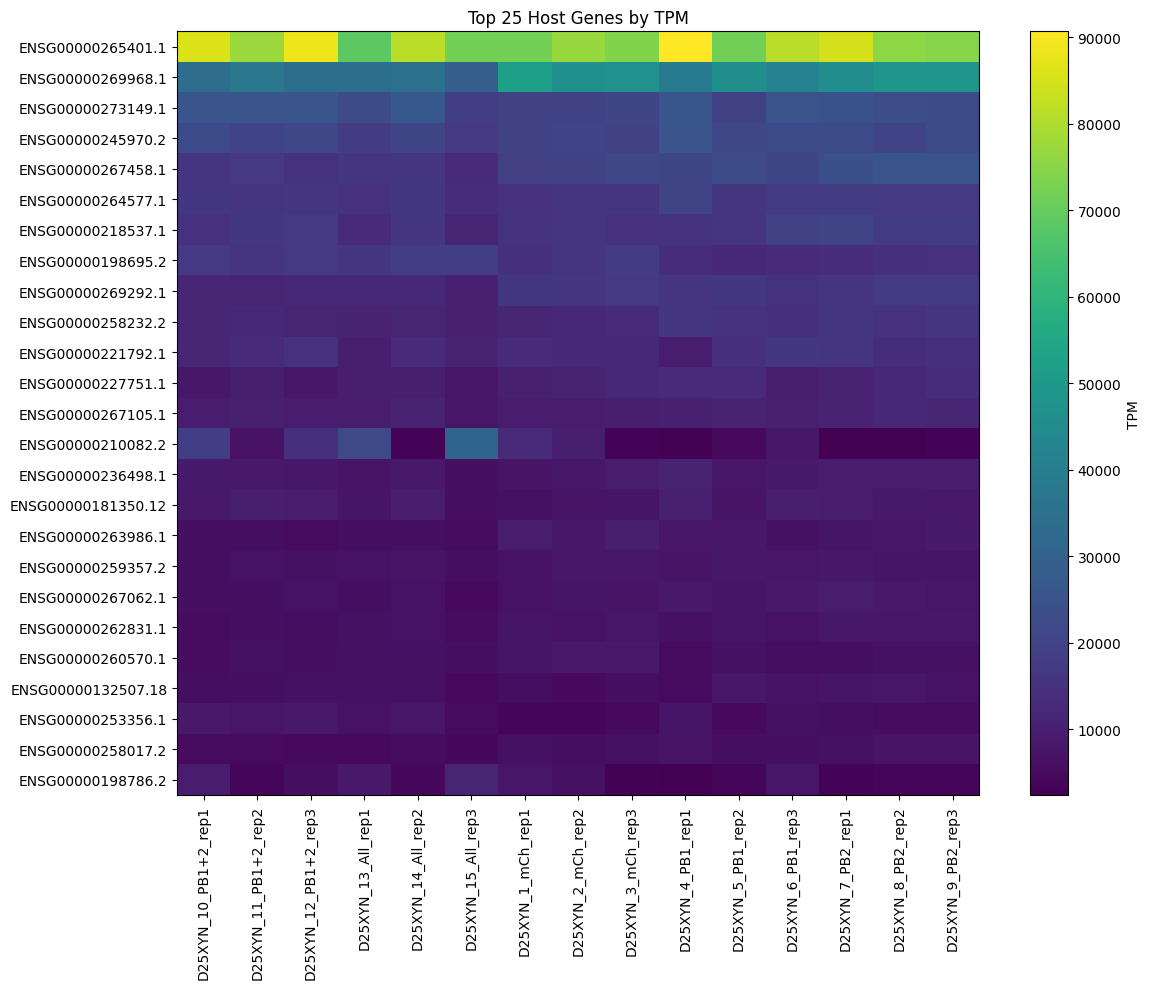

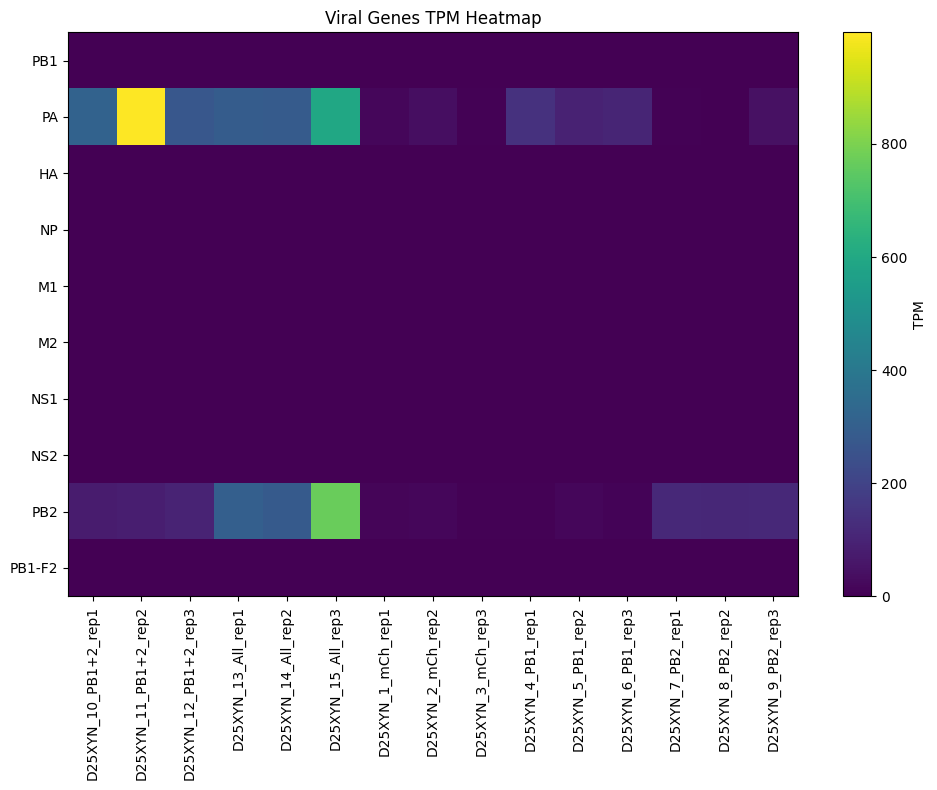

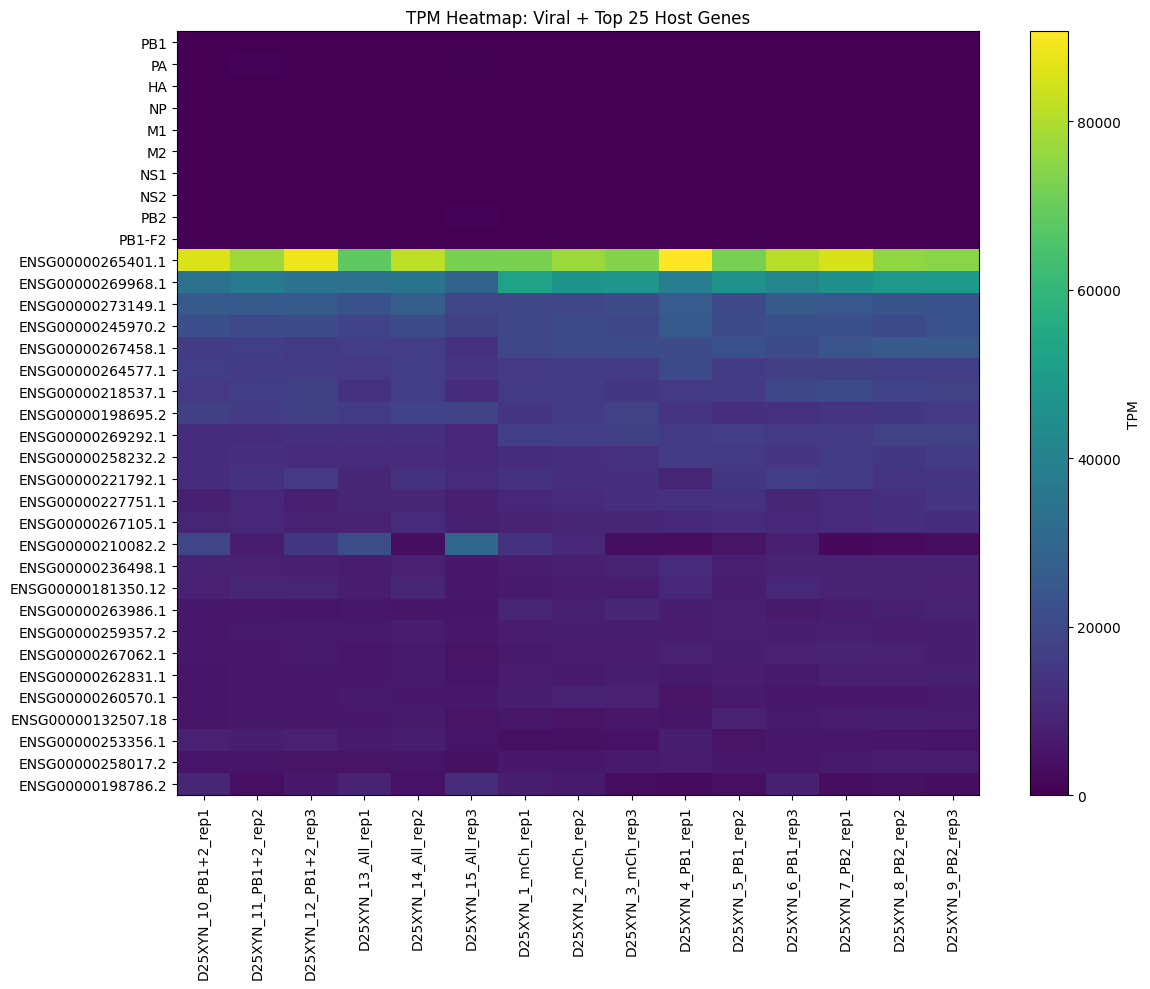

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# -----------------------------------------------
# LOAD FEATURECOUNTS TABLE (SKIP COMMENT LINES)
# -----------------------------------------------
df = pd.read_csv("counts_PE_fluWSN_hg38.txt", sep="\t", comment="#")

# Columns:
# 0 Geneid, 1 Chr, 2 Start, 3 End, 4 Strand, 5 Length, 6+ sample counts

# -----------------------------------------------
# CLEAN SAMPLE COLUMN NAMES
# -----------------------------------------------
raw_sample_cols = df.columns[6:]
clean_cols = []

for col in raw_sample_cols:
    base = col.split("/")[-1]   # remove path
    base = re.sub("_Aligned.sortedByCoord.out.bam$", "", base)
    clean_cols.append(base)

df.rename(columns=dict(zip(raw_sample_cols, clean_cols)), inplace=True)
count_cols = clean_cols  # numeric-only count columns


# -----------------------------------------------
# EXTRACT NUMERIC COUNT MATRIX
# -----------------------------------------------
counts = df[count_cols].apply(pd.to_numeric, errors="coerce")
gene_lengths = df["Length"].astype(float)  # ensure numeric


# -----------------------------------------------
# CALCULATE CPM
# -----------------------------------------------
library_sizes = counts.sum(axis=0)
cpm = counts.div(library_sizes, axis=1) * 1e6
cpm.insert(0, "Geneid", df["Geneid"])
cpm.to_csv("CPM_output.tsv", sep="\t", index=False)


# -----------------------------------------------
# CALCULATE TPM
# -----------------------------------------------
# RPK = counts / (length_kb)
rpk = counts.div(gene_lengths / 1000, axis=0)

# scaling = sum(RPK) / 1e6
scaling_factors = rpk.sum(axis=0) / 1e6

# TPM = rpk / scaling
tpm = rpk.div(scaling_factors, axis=1)
tpm.insert(0, "Geneid", df["Geneid"])
tpm.to_csv("TPM_output.tsv", sep="\t", index=False)


# -----------------------------------------------
# DEFINE VIRAL GENES
# -----------------------------------------------
viral_genes = [
    "PB1", "PA", "HA", "NP", "NA",
    "M1", "M2", "NS1", "NS2",
    "PB2", "PB1-F2"
]

tpm_matrix = tpm.set_index("Geneid")


# -----------------------------------------------
# 1) HEATMAP: TOP 25 HOST GENES
# -----------------------------------------------
# Remove viral genes from ranking
host_only = tpm_matrix.drop(index=tpm_matrix.index.intersection(viral_genes))

top25_host = host_only.sum(axis=1).sort_values(ascending=False).head(25).index
heat_host = tpm_matrix.loc[top25_host]

plt.figure(figsize=(12, 10))
plt.imshow(heat_host, aspect="auto")
plt.colorbar(label="TPM")
plt.xticks(range(len(heat_host.columns)), heat_host.columns, rotation=90)
plt.yticks(range(len(heat_host.index)), heat_host.index)
plt.title("Top 25 Host Genes by TPM")
plt.tight_layout()
plt.savefig("heatmap_top25_host.png", dpi=300)


# -----------------------------------------------
# 2) HEATMAP: VIRAL GENES
# -----------------------------------------------
viral_present = [g for g in viral_genes if g in tpm_matrix.index]

heat_viral = tpm_matrix.loc[viral_present]

plt.figure(figsize=(10, 8))
plt.imshow(heat_viral, aspect="auto")
plt.colorbar(label="TPM")
plt.xticks(range(len(heat_viral.columns)), heat_viral.columns, rotation=90)
plt.yticks(range(len(heat_viral.index)), heat_viral.index)
plt.title("Viral Genes TPM Heatmap")
plt.tight_layout()
plt.savefig("heatmap_viral_genes.png", dpi=300)


# -----------------------------------------------
# 3) HEATMAP: COMBINED (TOP 25 HOST + VIRAL)
# -----------------------------------------------
combined_genes = list(viral_present) + list(top25_host)
heat_combined = tpm_matrix.loc[combined_genes]

plt.figure(figsize=(12, 10))
plt.imshow(heat_combined, aspect="auto")
plt.colorbar(label="TPM")
plt.xticks(range(len(heat_combined.columns)), heat_combined.columns, rotation=90)
plt.yticks(range(len(heat_combined.index)), heat_combined.index)
plt.title("TPM Heatmap: Viral + Top 25 Host Genes")
plt.tight_layout()
plt.savefig("heatmap_combined.png", dpi=300)

print("✔ All outputs generated:")
print("   - CPM_output.tsv")
print("   - TPM_output.tsv")
print("   - heatmap_top25_host.png")
print("   - heatmap_viral_genes.png")
print("   - heatmap_combined.png")


In [23]:
tpm_sorted = tpm.set_index("Geneid")
tpm_sorted = tpm_sorted.loc[tpm_sorted.sum(axis=1).sort_values(ascending=False).index]

tpm_sorted.to_csv("TPM_sorted_by_total.tsv", sep="\t")

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os

# ============================================================
# LOAD FEATURECOUNTS TABLE
# ============================================================
df = pd.read_csv("counts_PE_fluWSN_hg38.txt", sep="\t", comment="#")

# Columns:
# 0 Geneid, 1 Chr, 2 Start, 3 End, 4 Strand, 5 Length, 6+ samples

raw_sample_cols = df.columns[6:]
clean_cols = []

# ============================================================
# CLEAN SAMPLE COLUMN NAMES
# ============================================================
for col in raw_sample_cols:
    base = col.split("/")[-1]
    base = re.sub("_Aligned.sortedByCoord.out.bam$", "", base)
    clean_cols.append(base)

df.rename(columns=dict(zip(raw_sample_cols, clean_cols)), inplace=True)
count_cols = clean_cols

# Extract numeric count matrix
counts = df[count_cols].apply(pd.to_numeric, errors="coerce")
gene_lengths = df["Length"].astype(float)


# ============================================================
# CPM CALCULATION
# ============================================================
library_sizes = counts.sum(axis=0)
cpm = counts.div(library_sizes, axis=1) * 1e6
cpm.insert(0, "Geneid", df["Geneid"])
cpm.to_csv("CPM_output.tsv", sep="\t", index=False)


# ============================================================
# TPM CALCULATION
# ============================================================
rpk = counts.div(gene_lengths / 1000, axis=0)
scaling_factors = rpk.sum(axis=0) / 1e6
tpm = rpk.div(scaling_factors, axis=1)
tpm.insert(0, "Geneid", df["Geneid"])
tpm.to_csv("TPM_output.tsv", sep="\t", index=False)

tpm_matrix = tpm.set_index("Geneid")


# ============================================================
# DEFINE VIRAL GENES
# ============================================================
viral_genes = ["PB1", "PA", "HA", "NP", "NA",
               "M1", "M2", "NS1", "NS2",
               "PB2", "PB1-F2"]

viral_present = [g for g in viral_genes if g in tpm_matrix.index]


# ============================================================
# GROUP SAMPLES INTO CONDITIONS
# (extract condition between number and "rep#")
# ============================================================
conditions = {}

for sample in count_cols:
    # Pattern: D25XYN_<number>_<condition>_rep<number>
    m = re.search(r"^[^_]+_\d+_(.+?)_rep\d+$", sample)
    if m:
        condition = m.group(1)
        conditions.setdefault(condition, []).append(sample)
    else:
        print("WARNING: Could not parse condition for:", sample)

print("\nDetected conditions + replicates:")
for c, r in conditions.items():
    print(f"{c}: {r}")


# ============================================================
# GENERATE HEATMAPS FOR EACH CONDITION
# ============================================================
os.makedirs("heatmaps_by_condition", exist_ok=True)

for condition, samples in conditions.items():
    print(f"\n▶ Generating heatmaps for condition: {condition}")

    # TPM submatrix for this condition's replicates
    tpm_sub = tpm_matrix[samples]

    # -------- TOP 25 HOST GENES ----------
    host_only = tpm_sub.drop(index=tpm_sub.index.intersection(viral_genes))
    top25 = host_only.sum(axis=1).sort_values(ascending=False).head(25).index
    heat_host = tpm_sub.loc[top25]

    plt.figure(figsize=(10, 8))
    plt.imshow(heat_host, aspect="auto")
    plt.colorbar(label="TPM")
    plt.xticks(range(len(samples)), samples, rotation=90)
    plt.yticks(range(len(top25)), top25)
    plt.title(f"{condition}: Top 25 Host Genes (TPM)")
    plt.tight_layout()
    plt.savefig(f"heatmaps_by_condition/{condition}_top25_host.png", dpi=300)
    plt.close()

    # -------- VIRAL GENES ----------
    viral_here = [g for g in viral_present if g in tpm_sub.index]
    if len(viral_here) > 0:
        heat_viral = tpm_sub.loc[viral_here]

        plt.figure(figsize=(8, 6))
        plt.imshow(heat_viral, aspect="auto")
        plt.colorbar(label="TPM")
        plt.xticks(range(len(samples)), samples, rotation=90)
        plt.yticks(range(len(viral_here)), viral_here)
        plt.title(f"{condition}: Viral Genes TPM")
        plt.tight_layout()
        plt.savefig(f"heatmaps_by_condition/{condition}_viral.png", dpi=300)
        plt.close()

    # -------- COMBINED ----------
    combined_genes = list(top25) + viral_here
    heat_combined = tpm_sub.loc[combined_genes]

    plt.figure(figsize=(10, 10))
    plt.imshow(heat_combined, aspect="auto")
    plt.colorbar(label="TPM")
    plt.xticks(range(len(samples)), samples, rotation=90)
    plt.yticks(range(len(combined_genes)), combined_genes)
    plt.title(f"{condition}: Viral + Top 25 Host Genes")
    plt.tight_layout()
    plt.savefig(f"heatmaps_by_condition/{condition}_combined.png", dpi=300)
    plt.close()

print("\n✔ DONE! All heatmaps saved in: heatmaps_by_condition/")
print("✔ TPM_output.tsv and CPM_output.tsv created.")


PB1+2
PB1+2
PB1+2
All
All
All
mCh
mCh
mCh
PB1
PB1
PB1
PB2
PB2
PB2

Detected conditions + replicates:
PB1+2: ['D25XYN_10_PB1+2_rep1', 'D25XYN_11_PB1+2_rep2', 'D25XYN_12_PB1+2_rep3']
All: ['D25XYN_13_All_rep1', 'D25XYN_14_All_rep2', 'D25XYN_15_All_rep3']
mCh: ['D25XYN_1_mCh_rep1', 'D25XYN_2_mCh_rep2', 'D25XYN_3_mCh_rep3']
PB1: ['D25XYN_4_PB1_rep1', 'D25XYN_5_PB1_rep2', 'D25XYN_6_PB1_rep3']
PB2: ['D25XYN_7_PB2_rep1', 'D25XYN_8_PB2_rep2', 'D25XYN_9_PB2_rep3']

▶ Generating heatmaps for condition: PB1+2

▶ Generating heatmaps for condition: All

▶ Generating heatmaps for condition: mCh

▶ Generating heatmaps for condition: PB1

▶ Generating heatmaps for condition: PB2

✔ DONE! All heatmaps saved in: heatmaps_by_condition/
✔ TPM_output.tsv and CPM_output.tsv created.
